<a href="https://colab.research.google.com/github/mehedihasanbijoy/PyTorch-Speech-Processing/blob/main/Projects/Audio%20Classification%201%20(UrbanSound8K)/CNN_UrbanSound8KClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade

In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/chrisfilo/urbansound8k')

100%|██████████| 5.61G/5.61G [01:04<00:00, 93.5MB/s]


In [ ]:
import pandas as pd
import torch
import torchaudio
import os
import glob
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def extract_audio_file_name(path):
    return path.split("/")[-1]

In [ ]:
all_paths = glob.glob("/content/urbansound8k/*/*.wav")

df = pd.DataFrame({"path": all_paths})
df['audio_file_name'] = df['path'].apply(extract_audio_file_name)
df = df.sort_values(by = "audio_file_name")

In [ ]:
annotation_df = pd.read_csv("/content/urbansound8k/UrbanSound8K.csv")
annotation_df = annotation_df.sort_values(by = "slice_file_name")

annotation_df['path'] = df['path'].values

annotation_df = annotation_df[["path", "slice_file_name", "fsID", "start", "end", "salience", "fold", "classID", "class"]]
annotation_df = annotation_df.sample(frac=1, random_state=32)
annotation_df = annotation_df.reset_index(drop=True)
annotation_df

,path,slice_file_name,fsID,start,end,salience,fold,classID,class
0,/content/urbansound8k/fold2/113201-5-0-6.wav,113201-5-0-6.wav,113201,3.000000,7.000000,1,2,5,engine_idling
1,/content/urbansound8k/fold4/55018-0-0-116.wav,55018-0-0-116.wav,55018,62.041583,66.041583,1,4,0,air_conditioner
2,/content/urbansound8k/fold8/160016-2-0-13.wav,160016-2-0-13.wav,160016,6.500000,10.500000,2,8,2,children_playing
3,/content/urbansound8k/fold6/107842-4-0-1.wav,107842-4-0-1.wav,107842,1.657328,5.657328,1,6,4,drilling
4,/content/urbansound8k/fold6/24364-4-0-0.wav,24364-4-0-0.wav,24364,0.633371,4.633371,1,6,4,drilling
...,...,...,...,...,...,...,...,...,...
8727,/content/urbansound8k/fold9/187075-5-0-2.wav,187075-5-0-2.wav,187075,4.446779,8.446779,2,9,5,engine_idling
8728,/content/urbansound8k/fold9/165567-3-0-0.wav,165567-3-0-0.wav,165567,0.147106,4.147106,2,9,3,dog_bark
8729,/content/urbansound8k/fold10/93567-8-0-10.wav,93567-8-0-10.wav,93567,9.044365,13.044365,2,10,8,siren
8730,/content/urbansound8k/fold9/72265-3-4-0.wav,72265-3-4-0.wav,72265,31.024479,33.127833,2,9,3,dog_bark


In [ ]:
train_df = annotation_df.iloc[:int(len(annotation_df)*.8), :]
test_df = annotation_df.iloc[int(len(annotation_df)*.8):, :]

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(test_df)

(6985, 1747)

In [ ]:
classes = sorted(list(set(annotation_df['class'].values)))
classes

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [ ]:
class UrbanSound8K(torch.utils.data.Dataset):
    def __init__(self, df, target_sample_rate, num_samples, transformation=None):
        self.df = df
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.transformation = transformation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df['path'][idx]
        audio_label = self.df['classID'][idx]
        audio_signal, sr = torchaudio.load(audio_path)

        audio_signal = self._resample_if_necessary(audio_signal, sr)
        audio_signal = self._mix_down_if_necessary(audio_signal)
        audio_signal = self._cut_down_if_necessary(audio_signal)
        audio_signal = self._right_pad_if_necessary(audio_signal)

        if self.transformation:
            audio_signal = self.transformation(audio_signal)

        return audio_signal, torch.tensor(audio_label)


    def _right_pad_if_necessary(self, audio_signal):
        audio_signal_length = audio_signal.shape[1]
        if audio_signal_length < self.num_samples:
            num_missing_samples = self.num_samples - audio_signal_length
            last_dim_padding = (0, num_missing_samples)
            audio_signal = torch.nn.functional.pad(audio_signal, last_dim_padding)
        return audio_signal


    def _cut_down_if_necessary(self, audio_signal):
        if audio_signal.shape[1] > self.num_samples:
            audio_signal = audio_signal[:, :self.num_samples]
        return audio_signal


    def _mix_down_if_necessary(self, audio_signal):
        if audio_signal.shape[0] > 1:
            audio_signal = torch.mean(audio_signal, dim=0, keepdim=True)
        return audio_signal


    def _resample_if_necessary(self, audio_signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            audio_signal = resampler(audio_signal)
        return audio_signal

In [ ]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

MEL_SPECTROGRAM = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset = UrbanSound8K(
    df = train_df,
    target_sample_rate = SAMPLE_RATE,
    num_samples = NUM_SAMPLES,
    transformation = MEL_SPECTROGRAM,
)
test_dataset = UrbanSound8K(
    df = test_df,
    target_sample_rate = SAMPLE_RATE,
    num_samples = NUM_SAMPLES,
    transformation = MEL_SPECTROGRAM,
)


train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True,
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False,
)

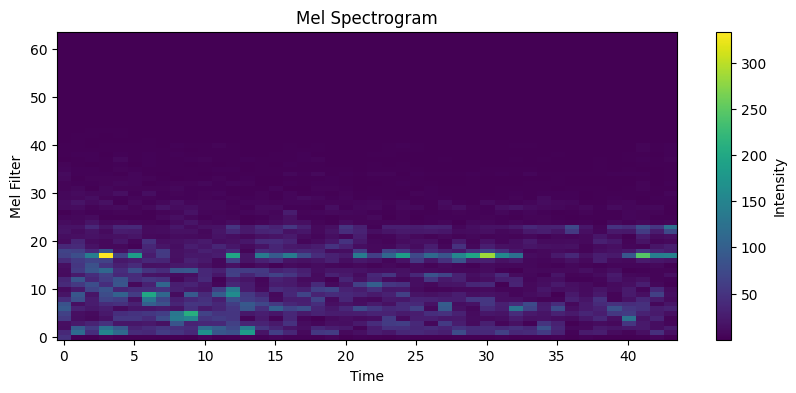

In [ ]:
audio, label = train_dataset.__getitem__(10)
label, audio.shape
# audio

plt.figure(figsize=(10, 4))
plt.imshow(audio.numpy()[0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Time')
plt.ylabel('Mel Filter')
plt.title('Mel Spectrogram')
plt.show()

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 2)
        self.conv2 = torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 2)
        self.conv3 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 2)
        self.conv4 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 2)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = torch.nn.Linear(in_features = 64*5*4, out_features = 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.maxpool(self.relu(self.conv3(x)))
        x = self.maxpool(self.relu(self.conv4(x)))
        x = torch.flatten(x, start_dim = 1) # Alternative flatten approaches: (1) x = x.view(x.size(0), -1), (2) x = x.reshape(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
def train(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    predictions, targets = [], []

    for (audio_signals, labels) in data_loader:
        audio_signals, labels = audio_signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(audio_signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, outputs = outputs.max(1)
        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    epoch_loss /= len(data_loader)

    pr = metrics.precision_score(targets, predictions, average="macro")
    re = metrics.recall_score(targets, predictions, average="macro")
    f1 = metrics.f1_score(targets, predictions, average="macro")
    ac = metrics.accuracy_score(targets, predictions)

    return (epoch_loss, ac, pr, re, f1)


In [ ]:
def test(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    predictions, targets = [], []

    data_loader = tqdm(data_loader, desc=f'Testing...', leave=False)

    with torch.no_grad():
        for (audio_signals, labels) in data_loader:
            audio_signals, labels = audio_signals.to(device), labels.to(device)
            outputs = model(audio_signals)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            _, outputs = outputs.max(1)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())

        epoch_loss /= len(data_loader)

        pr = metrics.precision_score(targets, predictions, average="macro")
        re = metrics.recall_score(targets, predictions, average="macro")
        f1 = metrics.f1_score(targets, predictions, average="macro")
        ac = metrics.accuracy_score(targets, predictions)

    return (epoch_loss, ac, pr, re, f1)

In [ ]:
model = CNN().to(DEVICE)

In [ ]:
N_EPOCHS = 20
LEARNING_RATE = 0.001
CRITERION = torch.nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
for epoch in range(N_EPOCHS):
    epoch_loss, ac, pr, re, f1 = train(
        model,
        data_loader=tqdm(train_loader, desc=f'Epoch {epoch + 1}/{N_EPOCHS}', leave=False),
        optimizer=OPTIMIZER,
        criterion=CRITERION,
        device=DEVICE
    )
    print(f'[Epoch - {epoch+1}] Training Loss: {epoch_loss:.4f}, Accuracy: {ac*100:.2f}%, Precision: {pr:.4f}, Recall: {re:.4f}, F1 Score: {f1:.4f}')

    epoch_loss, ac, pr, re, f1 = test(model, data_loader=test_loader, criterion=CRITERION, device=DEVICE)
    print(f'Test Loss: {epoch_loss:.4f}, Accuracy: {ac*100:.2f}%, Precision: {pr:.4f}, Recall: {re:.4f}, F1 Score: {f1:.4f}\n')


[Epoch - 1] Training Loss: 2.0562, Accuracy: 35.22%, Precision: 0.4314, Recall: 0.3584, F1 Score: 0.3708


Test Loss: 1.7954, Accuracy: 40.93%, Precision: 0.5390, Recall: 0.4110, F1 Score: 0.4266



[Epoch - 2] Training Loss: 1.6184, Accuracy: 45.28%, Precision: 0.5558, Recall: 0.4548, F1 Score: 0.4741


Test Loss: 1.5810, Accuracy: 49.69%, Precision: 0.5738, Recall: 0.4960, F1 Score: 0.5118



[Epoch - 3] Training Loss: 1.4726, Accuracy: 50.77%, Precision: 0.5754, Recall: 0.5116, F1 Score: 0.5281


Test Loss: 1.5058, Accuracy: 50.49%, Precision: 0.5783, Recall: 0.5117, F1 Score: 0.5254



[Epoch - 4] Training Loss: 1.3856, Accuracy: 52.95%, Precision: 0.5720, Recall: 0.5373, F1 Score: 0.5469


Test Loss: 1.5291, Accuracy: 51.86%, Precision: 0.5983, Recall: 0.5295, F1 Score: 0.5402



[Epoch - 5] Training Loss: 1.2751, Accuracy: 57.22%, Precision: 0.6098, Recall: 0.5807, F1 Score: 0.5893


Test Loss: 1.4046, Accuracy: 56.61%, Precision: 0.6020, Recall: 0.5734, F1 Score: 0.5803



[Epoch - 6] Training Loss: 1.1510, Accuracy: 61.75%, Precision: 0.6579, Recall: 0.6295, F1 Score: 0.6386


Test Loss: 1.3825, Accuracy: 58.90%, Precision: 0.6450, Recall: 0.6052, F1 Score: 0.6112



[Epoch - 7] Training Loss: 1.1552, Accuracy: 62.01%, Precision: 0.6557, Recall: 0.6330, F1 Score: 0.6403


Test Loss: 1.3484, Accuracy: 61.42%, Precision: 0.6673, Recall: 0.6210, F1 Score: 0.6360



[Epoch - 8] Training Loss: 1.1351, Accuracy: 62.44%, Precision: 0.6544, Recall: 0.6376, F1 Score: 0.6428


Test Loss: 1.4540, Accuracy: 59.13%, Precision: 0.6293, Recall: 0.6097, F1 Score: 0.6080



[Epoch - 9] Training Loss: 1.0653, Accuracy: 65.57%, Precision: 0.6869, Recall: 0.6680, F1 Score: 0.6743


Test Loss: 1.2632, Accuracy: 61.08%, Precision: 0.6642, Recall: 0.6287, F1 Score: 0.6294



[Epoch - 10] Training Loss: 0.9998, Accuracy: 67.90%, Precision: 0.7054, Recall: 0.6905, F1 Score: 0.6959


Test Loss: 1.3707, Accuracy: 58.21%, Precision: 0.6885, Recall: 0.5928, F1 Score: 0.6072



[Epoch - 11] Training Loss: 0.9896, Accuracy: 67.78%, Precision: 0.7051, Recall: 0.6881, F1 Score: 0.6937


Test Loss: 1.3075, Accuracy: 62.68%, Precision: 0.6535, Recall: 0.6501, F1 Score: 0.6481



[Epoch - 12] Training Loss: 0.8754, Accuracy: 71.06%, Precision: 0.7344, Recall: 0.7223, F1 Score: 0.7266


Test Loss: 1.2561, Accuracy: 65.94%, Precision: 0.6907, Recall: 0.6799, F1 Score: 0.6817



[Epoch - 13] Training Loss: 0.8710, Accuracy: 71.22%, Precision: 0.7376, Recall: 0.7243, F1 Score: 0.7294


Test Loss: 1.3212, Accuracy: 66.97%, Precision: 0.7196, Recall: 0.6853, F1 Score: 0.6921



[Epoch - 14] Training Loss: 0.9321, Accuracy: 70.80%, Precision: 0.7345, Recall: 0.7198, F1 Score: 0.7255


Test Loss: 1.4406, Accuracy: 61.36%, Precision: 0.6680, Recall: 0.6371, F1 Score: 0.6338



[Epoch - 15] Training Loss: 0.8319, Accuracy: 72.43%, Precision: 0.7479, Recall: 0.7357, F1 Score: 0.7398


Test Loss: 1.4388, Accuracy: 69.26%, Precision: 0.7241, Recall: 0.7062, F1 Score: 0.7106



[Epoch - 16] Training Loss: 0.8765, Accuracy: 72.78%, Precision: 0.7459, Recall: 0.7368, F1 Score: 0.7400


Test Loss: 1.3590, Accuracy: 69.43%, Precision: 0.7230, Recall: 0.7072, F1 Score: 0.7137



[Epoch - 17] Training Loss: 0.7079, Accuracy: 76.81%, Precision: 0.7904, Recall: 0.7770, F1 Score: 0.7818


Test Loss: 1.3015, Accuracy: 68.23%, Precision: 0.7128, Recall: 0.6968, F1 Score: 0.7022



[Epoch - 18] Training Loss: 0.7767, Accuracy: 75.70%, Precision: 0.7769, Recall: 0.7655, F1 Score: 0.7696


Test Loss: 1.2184, Accuracy: 70.18%, Precision: 0.7248, Recall: 0.7170, F1 Score: 0.7189



[Epoch - 19] Training Loss: 0.6898, Accuracy: 77.69%, Precision: 0.7948, Recall: 0.7838, F1 Score: 0.7879


Test Loss: 1.2449, Accuracy: 70.69%, Precision: 0.7377, Recall: 0.7214, F1 Score: 0.7212



[Epoch - 20] Training Loss: 0.6306, Accuracy: 79.40%, Precision: 0.8100, Recall: 0.8029, F1 Score: 0.8051


Test Loss: 1.3002, Accuracy: 72.12%, Precision: 0.7437, Recall: 0.7272, F1 Score: 0.7275

